## ETL and Preprocessing from Chapter 2 of GNNs in Action

## I. Introduction and Setup

This notebook covers the ETL and preprocessing steps for Chapter 2 of GNNs in Action. We’ll walk through creating a graph, loading it into NetworkX, performing light EDA, and finally preprocessing the graph into a PyG dataset for training.

This notebook covers the steps to:
1. Create a graph in both Edge List and Adjacency List formats, saving them into text files.
2. Load the graph into NetworkX using the adjacency list.
3. Perform light Exploratory Data Analysis (EDA) and visualization with NetworkX.
4. Pre-process the graph into a Pytorch Geometric (PyG) dataset for training.


## II. Download Raw Data
We begin by downloading raw data files, which include JSON and CSV files, from a shared Google Drive link.

In [10]:
!gdown https://drive.google.com/uc?id=1xITW9zRpkzi0tuebj2e9GIFa5jvokbqF # download sample json file
!gdown https://drive.google.com/uc?id=1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ # download sample csv file

Downloading...
From: https://drive.google.com/uc?id=1xITW9zRpkzi0tuebj2e9GIFa5jvokbqF
To: /content/relationships_hashed.json
100% 964k/964k [00:00<00:00, 76.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ
To: /content/node_attributes_hashed.csv
100% 155k/155k [00:00<00:00, 52.5MB/s]


## III. Import Libraries and Load Data
Next, we’ll import the necessary libraries and load the data into memory.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import count
import json
from multiprocessing import Pool
import matplotlib.pyplot as plt

## IV. Load Node Attributes
We’re loading the CSV file of node properties into a Pandas DataFrame and then converting it into a dictionary.

In [3]:
node_attr = pd.read_csv('node_attributes_hashed.csv', encoding = "ISO-8859-1")
node_attr = node_attr[['hashedid','company_type','position_type']]
node_attr.info()

node_attr = node_attr.set_index('hashedid')
# node_attr.tail()
attribute_dict = node_attr.to_dict(orient='index')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hashedid       1947 non-null   object
 1   company_type   1947 non-null   object
 2   position_type  1947 non-null   object
dtypes: object(3)
memory usage: 45.8+ KB


In [13]:
# attribute_dict

## V. Load JSON File
This part is for loading a JSON file which contains information about the relationships between nodes.

In [4]:
# Opening JSON file
candidate_link_file = open('relationships_hashed.json')

# returns JSON object as a dictionary
adjacencies_from_candidate_referrals = json.load(candidate_link_file)

# Closing file
candidate_link_file.close()

In [5]:
len(set(adjacencies_from_candidate_referrals.keys()))

1855

## VI. Create Edge List and Adjacency List
This section is where we create both edge and adjacency lists from the loaded JSON file.

In [6]:
def create_adjacency_list(data_dict, suffix=''):
    '''
    This function is meant to illustrate the transformation of raw
    data into an adjacency list. It was created for the social graph
    use case.

    INPUT: a. a dictionary of candidate referrals where they keys
              are members who have referred other candidates, and
              the values are lists of the people who where referred.
           b. a suffix to append to the file name

    OUTPUT: i. An encoded adjacency list in a txt file.
            ii. A list of the node IDs found.
    '''

    # Initialize an empty list to store unique nodes
    list_of_nodes = []

    # Create a copy of the data dictionary to avoid RuntimeError
    data_dict_copy = data_dict.copy()

    # Iterate over all keys (source nodes) in the data dictionary
    for source_node in data_dict_copy.keys():

        # Add the source node to the list of nodes if it is not already present
        if source_node not in list_of_nodes:
            list_of_nodes.append(source_node)

        # Iterate over all nodes referred by the source node
        for y in data_dict_copy[source_node]:

            # Add the referred node to the list of nodes if it is not already present
            if y not in list_of_nodes:
                list_of_nodes.append(y)

            # If the referred node is not already a key in the dictionary, add it and
            # create a connection back to the source node
            if y not in data_dict:
                data_dict[y] = [source_node]
            # Otherwise, just add a connection back to the source node if it doesn't exist
            elif source_node not in data_dict[y]:
                data_dict[y].append(source_node)

    # Open a file with the given suffix to write the adjacency list
    with open("adjacency_list_{}.txt".format(suffix), "w+") as g:
        print("adjacency_list_{}.txt".format(suffix), "w+")
        # Iterate over all keys (nodes) in the updated dictionary
        for source_node in data_dict.keys():

            # Join the list of adjacent nodes into a string
            dt = ' '.join(data_dict[source_node])

            # Write the node and its adjacent nodes to the file
            g.write("{} {}\n".format(source_node, dt))

    # Print the total number of unique nodes found
    print(len(list_of_nodes))

    # Create an adjacency list by joining each list of adjacent nodes into a string
    adjacency_list = {k: ' '.join(v) for k, v in data_dict.items()}

    # Return the list of nodes and the adjacency list
    return list_of_nodes, adjacency_list

In [7]:
list_of_nodes_adj, candidate_dict = create_adjacency_list(adjacencies_from_candidate_referrals, 'candidates')

adjacency_list_candidates.txt w+
1933


In [8]:
# list_of_nodes_adj

In [9]:
graph_from_adj = nx.read_adjlist('adjacency_list_candidates.txt')
graph_from_adj.number_of_edges(), graph_from_adj.number_of_nodes()

(12239, 1933)

**Creation of Edge List**
*   The create_edge_list function takes in a dictionary of nodes and their connections and transforms it into an edge list.
*   It iteratively goes through each node and its connections, and for each unique pair, it adds them to an edge list.
*   This edge list is then written to a file for future use.
*   All unique nodes and edges are also returned from the function for additional processing or analysis.




In [10]:
# create edge list

def create_edge_list(data_dict, suffix=''):
    '''
    This function transforms a dictionary of nodes and their connections into an edge list and saves it to a file.

    INPUT:
      - data_dict: a dictionary where keys are nodes and values are lists of nodes that are connected to the key node.
      - suffix: a string to append to the end of the file name for the saved edge list.

    OUTPUT:
      - A text file containing the edge list.
      - A list of unique nodes found in the edge list.
      - A list of edges found in the edge list.
    '''
    # Opening a file to write the edge list. The file name is generated by appending the provided suffix.
    edge_list_file = open("edge_list_{}.txt".format(suffix), "w+")

    # A list to store the edges as they are found.
    list_of_edges = []

    # A list to store all the nodes found in the data_dict.
    list_of_nodes_all = []

    # Iterating over each node in the data_dict.
    for source_node in list(data_dict.keys()):
        # If the source_node is not already in the list_of_nodes_all, add it.
        if source_node not in list_of_nodes_all:
            list_of_nodes_all.append(source_node)

        # Getting the list of nodes connected to the source_node.
        list_of_connects = data_dict[source_node]

        # Iterating over each node connected to the source_node.
        for destination_node in list_of_connects:
            # If the destination node is not already in the list_of_nodes_all, add it.
            if destination_node not in list_of_nodes_all:
                list_of_nodes_all.append(destination_node)

            # If the edge {source_node, destination_node} is not already in the list_of_edges, add it.
            if {source_node, destination_node} not in list_of_edges:
                # Printing the edge to the console (this can be removed or commented out if not needed).
                print("{} {}".format(source_node, destination_node))

                # Writing the edge to the edge_list_file.
                edge_list_file.write("{} {} \n".format(source_node, destination_node))

                # Adding the edge to the list_of_edges.
                list_of_edges.append({source_node, destination_node})
            else:  # If the edge is already in the list_of_edges, skip it and continue to the next one.
                continue

    # Closing the edge list file after writing all edges to it.
    edge_list_file.close

    # Returning the list_of_edges and list_of_nodes_all as output.
    return list_of_edges, list_of_nodes_all


In [11]:
list_of_edges, list_of_nodes = create_edge_list(adjacencies_from_candidate_referrals, 'candidates')

b39ae65ebc89363c9dce2fd3ff73f58191cb8947 20e53a53a9875ce3c1beeac367c52699f69772ef
131e840479c73b6835c1a97872a436972fc142e5 b49b6a8f89d07370949d1eb1a19240f40398b7f8
ad63f970d01947ce1b2a9a14c92103c4252a0e86 03e4c9e8593fd47ca6df56bb56b3d5993da24ab4
ad63f970d01947ce1b2a9a14c92103c4252a0e86 4e3f27e72fb1a9b24a4b183e70ab7caeb95f6522
ad63f970d01947ce1b2a9a14c92103c4252a0e86 c79602b11d0c05a52f7617fbf21ed27cb2ef21f1
ad63f970d01947ce1b2a9a14c92103c4252a0e86 a35b358605ac639e00243d74ad98f4be7df5367d
ad63f970d01947ce1b2a9a14c92103c4252a0e86 6a14914bf66aa8c04e4b8261b148667218e469e4
ad63f970d01947ce1b2a9a14c92103c4252a0e86 5f31e4dbea313306f94be96c19433ae95d400159
ad63f970d01947ce1b2a9a14c92103c4252a0e86 8f3320fcb044b0f80725d22ad15752a6a46e1c8d
90876ef6ad4269c9457e5e13ffc394964a0ea82a 84c716209d8e221d02203ec7f2cb25262721d640
90876ef6ad4269c9457e5e13ffc394964a0ea82a 0921a7bde167696c7b64b6003ce018b09aa25648
90876ef6ad4269c9457e5e13ffc394964a0ea82a 97d1726f12a6f1d4a67e46e9251bb857f1d8df32
90876ef6ad4269c9

In [12]:
len(list_of_edges), len(list_of_nodes), len(list_of_nodes_adj)

(12239, 1933, 1933)

In [13]:
graph_from_edge_list = nx.read_edgelist('edge_list_candidates.txt')
graph_from_edge_list.number_of_edges(), graph_from_edge_list.number_of_nodes()

(12239, 1727)

## VII. Data Exploration
Now, we are delving into a section where we explore the data visually and statistically to gain insights.


*   load our adjacency list into NetworkX
*   Establish the number of nodes, edges and connected components
*   Select the large connected component for some visualizations and summary statistics



In [14]:
social_graph = nx.read_edgelist('edge_list_candidates.txt')
nx.set_node_attributes(social_graph, attribute_dict)
print(social_graph.number_of_nodes(), social_graph.number_of_edges())
# number of nodes and edges

1727 12239


In [15]:
social_graph = nx.read_adjlist('adjacency_list_candidates.txt')
nx.set_node_attributes(social_graph, attribute_dict)
print(social_graph.number_of_nodes(), social_graph.number_of_edges())

1933 12239


In [16]:
len(list((c for c in nx.connected_components(social_graph))))
# There are 219 connected components

219

In [17]:
sorted_components = sorted(list((len(c) for c in nx.connected_components(social_graph))), reverse=True)
set(sorted_components)
# We are able to determine that most of the disconnected components are made up of less
# than 4 nodes. Our interest is on the large component of 1698 nodes.


{1, 2, 3, 4, 1698}

In [18]:
# We use the 'job type' attribute to create groups that we
# can use in our visualizations.


groups = set(nx.get_node_attributes(social_graph,'position_type').values())
mapping = dict(zip(sorted(groups),count()))
values = [mapping[attribute_dict[node]['position_type']] if node in attribute_dict.keys() else .25 \
          for node in social_graph.nodes() ]

In [19]:
mapping

{'Unknown': 0,
 'education': 1,
 'engineer': 2,
 'executive_or_management': 3,
 'finance': 4,
 'legal': 5,
 'marketing_sales': 6,
 'misc': 7,
 'operations_supplychain': 8}

This below visualization is of the entire graph, including the disconnected components.

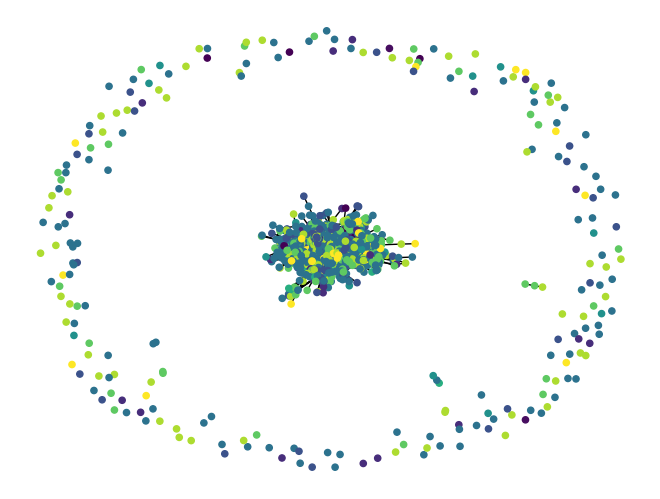

In [20]:
nx.draw(social_graph, cmap=plt.get_cmap('viridis'), node_color=values, node_size=20,with_labels=False, font_color='white')
plt.show()



The below script visualizes a social graph and its degree distribution. It first extracts the largest connected
component of the social graph and plots it with nodes colored by their 'position_type' attribute. The script
then computes the degree of each node in the social graph and uses this information to create a degree rank
plot and a degree histogram. The plots are arranged in a single figure using a custom grid layout.


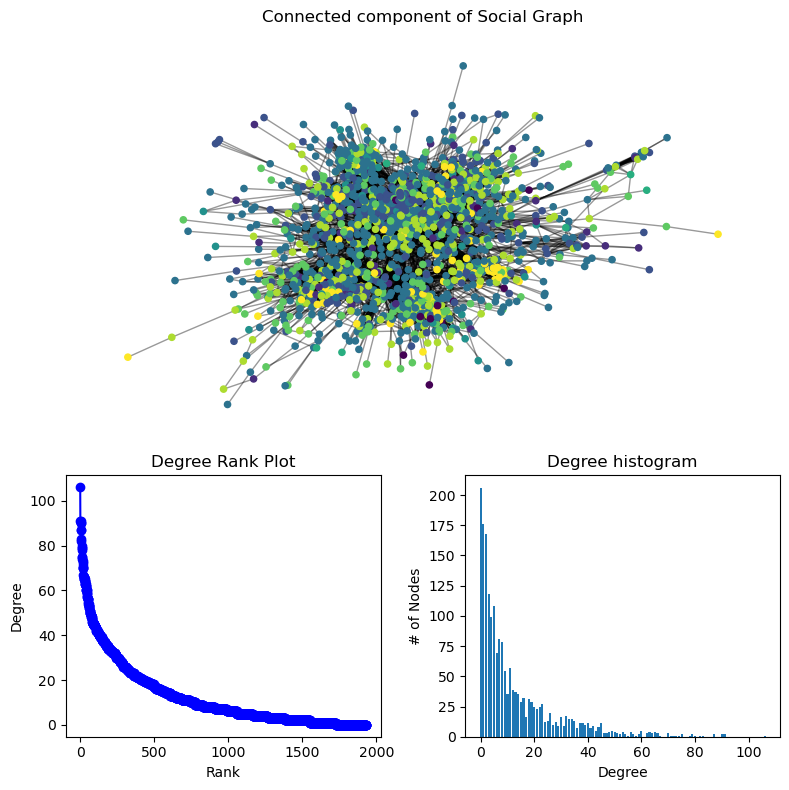

In [21]:
# Create a new figure for plotting the degree of a random graph with specified figure size
fig = plt.figure("Degree of a random graph", figsize=(8, 8))

# Create a grid specification of 5 rows and 4 columns to manage subplot arrangement
axgrid = fig.add_gridspec(5, 4)

# Add a subplot that occupies the first three rows and all columns of the grid
ax0 = fig.add_subplot(axgrid[0:3, :])

# Extract the largest connected component from the social graph (A)
Gcc = social_graph.subgraph(sorted(nx.connected_components(social_graph), key=len, reverse=True)[0])

# Retrieve unique values of the 'position_type' node attribute in the connected component
groups2 = set(nx.get_node_attributes(Gcc, 'position_type').values())

# Create a mapping of 'position_type' values to integers
mapping2 = dict(zip(sorted(groups2), count()))

# Obtain the integer representations of 'position_type' for all nodes in the connected component
values2 = [mapping2[attribute_dict[node]['position_type']] for node in Gcc.nodes()]

# Compute the spring layout positions for the nodes of the connected component with a given seed (B)
pos = nx.spring_layout(Gcc, seed=10396953)

# Draw nodes of the connected component using the spring layout positions and the mapped 'position_type' values as colors (C)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=values2)

# Draw edges of the connected component with specified transparency (D)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)

# Set the title of the subplot and turn off the axis
ax0.set_title("Connected component of Social Graph")
ax0.set_axis_off()

# Calculate the degree sequence of the social graph, sorted in descending order (E)
degree_sequence = sorted([d for n, d in social_graph.degree()], reverse=True)

# Add another subplot to the bottom left quarter of the grid for the degree rank plot
ax1 = fig.add_subplot(axgrid[3:, :2])

# Plot the degree rank plot with blue line and circle markers (F)
ax1.plot(degree_sequence, "b-", marker="o")

# Set the title, y-label, and x-label of the degree rank plot
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

# Add another subplot to the bottom right quarter of the grid for the degree histogram
ax2 = fig.add_subplot(axgrid[3:, 2:])

# Create a bar chart for the degree histogram (G)
ax2.bar(*np.unique(degree_sequence, return_counts=True))

# Set the title, x-label, and y-label of the degree histogram
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

# Adjust the layout to prevent overlap between subplots
fig.tight_layout()

# Display the complete figure with all subplots
plt.show()


The number of nodes and edges in our large connected component.

In [22]:
Gcc.number_of_edges(), Gcc.number_of_nodes()


(12222, 1698)

A (sparse) adjacency matrix of our entire social graph

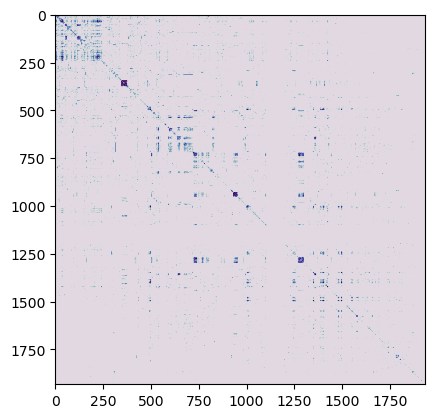

In [23]:

plt.imshow(nx.to_numpy_array(social_graph), aspect='equal',cmap='twilight')


## VIII. Preprocessing with Pytorch Geometric
This section will guide us on how to preprocess data with Pytorch Geometric.



*   Create directly from a NetworkX graph object
*   Using raw files.
*   Using Dataset classes with raw files
*   Using Data objects to directly create a dataloader without the Dataset class





In [24]:
! python -c "import torch; print(torch.__version__)"

2.1.0


In [25]:
! python -c "import torch; print(torch.version.cuda)"

None


In [26]:
# Install Pytorch Geometric
# Use the information above to fill in the first and second pip lines

# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-geometric

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      Traceback (most recent call last):
        File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
        File "/private/var/folders/t4/wnm8d6_s7tg87fzp2xpw_k6w0000gn/T/pip-build-env-od65qt24/overlay/lib/python3.7/site-packages/setuptools/build_meta.py", li

In [27]:
import torch

from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
# from torch_geometric import utils
from torch_geometric.utils.convert import to_networkx, from_networkx


Case A: Create PyG data object using NetworkX object


In [28]:

data = from_networkx(Gcc)


Case B: Create PyG data object using raw files


In [29]:
#A Load the adjacency list to form a graph using NetworkX.
social_graph = nx.read_adjlist('adjacency_list_candidates.txt')

#B Get all unique nodes from the graph. We use set to remove any duplicates and then convert it back to a list.
list_of_nodes = list(set(list(social_graph)))

#C Create a list of indices corresponding to each unique node. This will be used to map each node to an index.
indices_of_nodes = [list_of_nodes.index(x) for x in list_of_nodes]

#D Create a dictionary to map each node to its corresponding index.
node_to_index = dict(zip(list_of_nodes, indices_of_nodes))

# Creating the reverse mapping from index to node for easy lookup later.
index_to_node = dict(zip(indices_of_nodes, list_of_nodes))

#E Convert the graph to an edge list to extract all the edges present in the graph.
list_edges = nx.convert.to_edgelist(social_graph)
list_edges = list(list_edges)  # Converting edge view object to list for easier processing.

#F Split the edge list into two separate lists representing the two nodes that make up each edge.
named_edge_list_0 = [x[0] for x in list_edges]
named_edge_list_1 = [x[1] for x in list_edges]

#G Convert the node names in the edge list to their corresponding indices using the previously created mapping.
indexed_edge_list_0 = [node_to_index[x] for x in named_edge_list_0]
indexed_edge_list_1 = [node_to_index[x] for x in named_edge_list_1]

#H Create a feature matrix x. In this example, it’s a vector of ones, meaning each node has a feature vector of size 1 with a value of 1.
x = torch.FloatTensor([[1] for x in range(len(list_of_nodes))])

#I Create a target vector y, with values of 1 for the first 974 nodes and 0 for the next 973 nodes.
y = torch.FloatTensor([1]*974 + [0]*973)
y = y.long()  # Convert the floating point values to long integers.

#J Create an edge index tensor that contains all edges represented by the indices of the connected nodes. It's used to tell PyTorch Geometric about the connections in the graph.
edge_index = torch.tensor([indexed_edge_list_0, indexed_edge_list_1])

#K Create a training mask to identify which nodes will be used for training. It's initialized with zeros and then set to ones for nodes that are used for training.
train_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8)
train_mask[:int(0.8 * len(list_of_nodes))] = 1  # Use 80% of nodes for training.

# Creating a test mask for identifying which nodes will be used for testing.
test_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8)
test_mask[- int(0.2 * len(list_of_nodes)):] = 1  # Use remaining 20% of nodes for testing.
train_mask = train_mask.bool()  # Convert the training mask to boolean values.
test_mask = test_mask.bool()    # Convert the testing mask to boolean values.

#L Create a PyTorch Geometric data object. This object holds the graph data (features x, targets y, edge indices) and the masks for training and testing.
data = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, test_mask=test_mask)


Case C: Create PyG dataset object using custom class and input files


In [30]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):  #A
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self): #B
        return []

    @property
    def processed_file_names(self): #C
        return ['../test.dataset']

    def download(self): #D
        # Download to `self.raw_dir`.
        pass

    def process(self): #E
        # Read data into `Data` list.
        data_list = []

        eg = nx.read_edgelist('edge_list2.txt')

        list_of_nodes = list(set(list(eg)))
        indices_of_nodes = [list_of_nodes.index(x) for x in list_of_nodes]

        node_to_index = dict(zip(list_of_nodes, indices_of_nodes))
        index_to_node = dict(zip(indices_of_nodes, list_of_nodes))

        list_edges = nx.convert.to_edgelist(eg)
        list_edges = list(list_edges)
        named_edge_list_0 = [x[0] for x in list_edges]
        named_edge_list_1 = [x[1] for x in list_edges]

        indexed_edge_list_0 = [node_to_index[x] for x in named_edge_list_0]
        indexed_edge_list_1 = [node_to_index[x] for x in named_edge_list_1]

        x = torch.FloatTensor([[1] for x in range(len(list_of_nodes))])#  [[] for x in xrange(n)]
        y = torch.FloatTensor([1]*974 + [0]*973)
        y = y.long()

        edge_index = torch.tensor([indexed_edge_list_0, indexed_edge_list_1])

        train_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8)
        train_mask[:int(0.8 * len(list_of_nodes))] = 1 #train only on the 80% nodes
        test_mask = torch.zeros(len(list_of_nodes), dtype=torch.uint8) #test on 20 % nodes
        test_mask[- int(0.2 * len(list_of_nodes)):] = 1

        train_mask = train_mask.bool()

        test_mask = test_mask.bool()

        data_example = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, test_mask=test_mask) #F

        data_list.append(data_example) #G

        data, slices = self.collate(data_list)  #H
        torch.save((data, slices), self.processed_paths[0])  #I

Case D: Create PyG data objects for use in dataloader without use of a dataset object


In [31]:

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# data_list = [Data(...), ..., Data(...)]
# We'll use the data object from case B
data_list = [data]
loader = DataLoader(data_list, batch_size=32)


In [32]:
# Check if the loader is created and can load batches
try:
    for batch in loader:
        print(batch)
        print("Batch size:", len(batch))
except Exception as e:
    print("An error occurred:", e)

DataBatch(x=[1933, 1], edge_index=[2, 12239], y=[1947], train_mask=[1933], test_mask=[1933], batch=[1933], ptr=[2])
Batch size: 1


In [33]:
# Here, we replicate the data object to simulate multiple samples
data_list = [data] * 100  # Create a list containing 100 identical data objects

loader = DataLoader(data_list, batch_size=32)

# Verify the creation of the batches
for batch in loader:
    print(batch)

DataBatch(x=[61856, 1], edge_index=[2, 391648], y=[62304], train_mask=[61856], test_mask=[61856], batch=[61856], ptr=[33])
DataBatch(x=[61856, 1], edge_index=[2, 391648], y=[62304], train_mask=[61856], test_mask=[61856], batch=[61856], ptr=[33])
DataBatch(x=[61856, 1], edge_index=[2, 391648], y=[62304], train_mask=[61856], test_mask=[61856], batch=[61856], ptr=[33])
DataBatch(x=[7732, 1], edge_index=[2, 48956], y=[7788], train_mask=[7732], test_mask=[7732], batch=[7732], ptr=[5])


## Conclusion
We've covered the ETL and preprocessing steps in detail, providing insights into the handling and preparation of graph data for modeling with PyG. For the next set of chapter notebooks, we’ll be focusing on modeling and predictions.
